# Cards Model Test

In [299]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from jass.train.label_play import LabelPlay
from jass.logs.game_log_entry import GameLogEntry
from jass.game.game_state_util import state_from_complete_game, calculate_starting_hands_from_game
from jass.game.rule_schieber import RuleSchieber
from examples.io.convert_swisslos_log_to_games import LogParserSwisslos

In [300]:
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

user  = ['user']
trump = ['trump']
played_card  = ['played_card']

rule = RuleSchieber()

entries = []
path = Path("../jass-games") / "jass_game_0001.txt"
with open(path) as file:
    line = file.readline()
    #while line:
    for x in range(50000):
        content = json.loads(line)
        entry = GameLogEntry.from_json(content)
        entries.append(entry)
        line = file.readline()

#entries = LogParserSwisslos.parse_rounds(path)

rows = []

for entry in entries:
    for nrCards in range(0,34):
        round_state = state_from_complete_game(entry.game, nrCards)
        valid_cards = rule.get_valid_cards_from_state(round_state)# valid cards for player
        row = valid_cards
        
        row = np.append(row, round_state.trump)
        
        next_round_state = state_from_complete_game(entry.game, nrCards + 1)
        #print(round_state.current_trick)
        #print(next_round_state.tricks[round_state.nr_tricks])
        card = np.setdiff1d(next_round_state.tricks[round_state.nr_tricks], round_state.current_trick)
        #print(card)
        row = np.append(row,card[0])
        rows.append(row)

data =pd.DataFrame(data=rows ,columns=cards + trump + played_card)

pd.set_option('display.max_columns', None)
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,HK,HQ,HJ,H10,H9,H8,H7,H6,SA,SK,SQ,SJ,S10,S9,S8,S7,S6,CA,CK,CQ,CJ,C10,C9,C8,C7,C6,trump,played_card
0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,9
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14
2,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13
3,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,4
4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,30


## import player statistics

In [301]:
#stats = pd.read_json("04 Data/stat/player_all_stat.json")
#stats.head()

In [302]:
#stats.sort_values(by=['mean'], ascending=False)

# Drop bad players

In [303]:
#good_users = stats.loc[(stats['mean'] > 79) & (stats['nr'] > 5)]
#good_users

In [304]:
#data = data[data['user'].isin(good_users['id'])]
#data

# Training

In [305]:
from sklearn.model_selection import train_test_split
feature_columns = []


In [306]:
x_data = data[cards + trump + feature_columns]
y_data = data.played_card

In [307]:
X_train, X_test, y_train_data, y_test_data = train_test_split(x_data, y_data, test_size=0.2, stratify=data.played_card, random_state=42)

print(y_train_data)
#y_train_label = np.argmax(x_train, axis=1)
#y_categorical = tf.keras.utils.to_categorical(y_train_label, num_classes=4)

1427879    27
570583      0
1022463     5
320809     10
933715     13
           ..
1449789    25
852204      6
875922      9
651560     19
1277594    17
Name: played_card, Length: 1360000, dtype: int64


In [308]:
y_train = pd.get_dummies(y_train_data)
y_test = pd.get_dummies(y_test_data)
print(y_train)

         0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
1427879   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
570583    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1022463   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
320809    0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   
933715    0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   
...      ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
1449789   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
852204    0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
875922    0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   
651560    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1277594   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

         17  18  19  20  21  22  23  24  25  26  27

In [309]:
input_length = len(cards + trump + feature_columns)

model = keras.Sequential()
model.add(keras.layers.Dense(input_length, activation='relu', input_shape=[input_length]))
model.add(keras.layers.Dense(120, activation='relu'))
model.add(keras.layers.Dense(120, activation='relu'))
model.add(keras.layers.Dense(54, activation='relu'))
model.add(keras.layers.Dense(54, activation='relu'))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(36, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.25, epochs=300, batch_size=100)

Epoch 1/300
10200/10200 [==============================] - 20s 2ms/step - loss: 2.9379 - accuracy: 0.1924 - val_loss: 1.9171 - val_accuracy: 0.4315
Epoch 2/300
10200/10200 [==============================] - 20s 2ms/step - loss: 2.0570 - accuracy: 0.3837 - val_loss: 1.7103 - val_accuracy: 0.4676
Epoch 3/300
10200/10200 [==============================] - 20s 2ms/step - loss: 1.8901 - accuracy: 0.4102 - val_loss: 1.5790 - val_accuracy: 0.4751
Epoch 4/300
10200/10200 [==============================] - 20s 2ms/step - loss: 1.8118 - accuracy: 0.4223 - val_loss: 1.5290 - val_accuracy: 0.4827
Epoch 5/300
10200/10200 [==============================] - 20s 2ms/step - loss: 1.7646 - accuracy: 0.4296 - val_loss: 1.4768 - val_accuracy: 0.4908
Epoch 6/300
10200/10200 [==============================] - 20s 2ms/step - loss: 1.7277 - accuracy: 0.4360 - val_loss: 1.4547 - val_accuracy: 0.4937
Epoch 7/300
10200/10200 [==============================] - 20s 2ms/step - loss: 1.7027 - accuracy: 0.4389 - val_

10200/10200 [==============================] - 19s 2ms/step - loss: 1.4003 - accuracy: 0.5010 - val_loss: 1.1585 - val_accuracy: 0.5564
Epoch 110/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3998 - accuracy: 0.5010 - val_loss: 1.1629 - val_accuracy: 0.5521
Epoch 111/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3996 - accuracy: 0.5014 - val_loss: 1.1582 - val_accuracy: 0.5536
Epoch 112/300
10200/10200 [==============================] - 21s 2ms/step - loss: 1.3979 - accuracy: 0.5019 - val_loss: 1.1568 - val_accuracy: 0.5561
Epoch 113/300
10200/10200 [==============================] - 20s 2ms/step - loss: 1.3973 - accuracy: 0.5018 - val_loss: 1.1594 - val_accuracy: 0.5549
Epoch 114/300
10200/10200 [==============================] - 20s 2ms/step - loss: 1.3961 - accuracy: 0.5021 - val_loss: 1.1650 - val_accuracy: 0.5557
Epoch 115/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3955 - accuracy: 0.5021 - val_

Epoch 164/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3666 - accuracy: 0.5085 - val_loss: 1.1251 - val_accuracy: 0.5669
Epoch 165/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3661 - accuracy: 0.5087 - val_loss: 1.1286 - val_accuracy: 0.5646
Epoch 166/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3657 - accuracy: 0.5087 - val_loss: 1.1296 - val_accuracy: 0.5610
Epoch 167/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3650 - accuracy: 0.5085 - val_loss: 1.1267 - val_accuracy: 0.5632
Epoch 168/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3643 - accuracy: 0.5085 - val_loss: 1.1302 - val_accuracy: 0.5630
Epoch 169/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3641 - accuracy: 0.5093 - val_loss: 1.1222 - val_accuracy: 0.5644
Epoch 170/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3635 - accuracy:

Epoch 273/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3149 - accuracy: 0.5182 - val_loss: 1.0843 - val_accuracy: 0.5727
Epoch 274/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3138 - accuracy: 0.5179 - val_loss: 1.0847 - val_accuracy: 0.5716
Epoch 275/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3145 - accuracy: 0.5184 - val_loss: 1.0885 - val_accuracy: 0.5713
Epoch 276/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3135 - accuracy: 0.5190 - val_loss: 1.0871 - val_accuracy: 0.5689
Epoch 277/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3129 - accuracy: 0.5185 - val_loss: 1.0832 - val_accuracy: 0.5729
Epoch 278/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3124 - accuracy: 0.5183 - val_loss: 1.0843 - val_accuracy: 0.5689
Epoch 279/300
10200/10200 [==============================] - 19s 2ms/step - loss: 1.3129 - accuracy:

In [316]:
model.evaluate(X_test, y_test)

10625/10625 [==============================] - 15s 1ms/step - loss: 1.0889 - accuracy: 0.5696


[1.088873028755188, 0.5695676207542419]

Text(0, 0.5, 'loss')

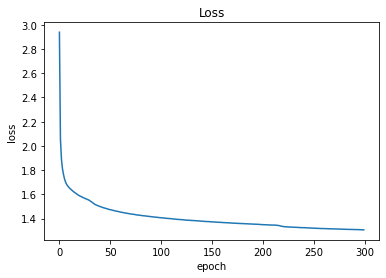

In [317]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

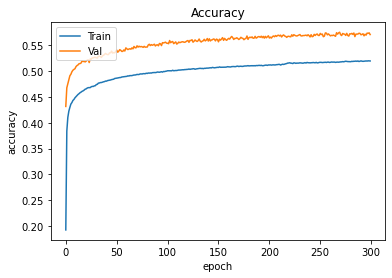

In [318]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# Predict

In [319]:
def deal_random_hand() -> np.ndarray:
    """
    Deal random hand.

    Returns:
        one hot encoded 1x36 array
    """
    # shuffle card ids
    cards = np.arange(0, 36, dtype=np.int32)
    np.random.shuffle(cards)
    hands = np.zeros(shape=[4, 36], dtype=np.int32)

    # convert to one hot encoded
    hands[0, cards[0:9]] = 1
    hands[1, cards[9:18]] = 1
    hands[2, cards[18:27]] = 1
    hands[3, cards[27:39]] = 1
    
    hand = np.append(hands[0], np.random.randint(0,5))

    return hand

In [1]:
hand = deal_random_hand()
#hand = np.array([[0,1,1,1,0,1,0,0,0, 0,0,0,0,1,0,0,1,0, 1,0,0,0,0,0,0,0,0, 0,0,0,0,0,1,0,0,1, 4]])
hand_df = pd.DataFrame(data=[hand], columns=cards+trump)

print(hand_df)
print("\n")
input_hand = np.array([hand_df.iloc[0].values])
prediction = model.predict(input_hand)
prediction = prediction * hand[:-1]
result = pd.DataFrame(data=prediction, columns=cards)
print(result)
result.idxmax(axis=1)

NameError: name 'deal_random_hand' is not defined

In [323]:
#model.save("E:/Work/cards_model50000_0569")

INFO:tensorflow:Assets written to: E:/Work/cards_model50000_0569\assets
